# Part 1
## Write your report here
### Step 0: Data Preparation
We choose June 2020 as our month of interest since this is the first month that data from most countries can be found from our dataset owid/covid-19-data.
We chose this data as it is comprehensive and live, being updated regularly as countries report their numbers, which would allow us to compare across countries as well as over time
We first pick a few features that may be related to total number of deaths and plot to visualize:
* 'population_density',
* 'total_cases',
* 'total_deaths',
* 'total_tests',
* 'gdp_per_capita',
* 'median_age',
* 'hospital_beds_per_thousand',
* 'human_development_index'

In [2]:
import datetime
import calendar
import pandas as pd
from typing import Tuple, List, Dict, Optional
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations, product
import re
import warnings

warnings.filterwarnings('ignore')
sns.set()
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1) 

In [3]:
class PrepData:
    '''
    Filter and create new feature columns
    '''
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
        # remove non-countries data
        self.df = self.df[~self.df["location"].isin(['World', 'Africa', 'Asia', 'Europe', 'European Union',
                                                    'High income', 'International', 'Low income', 
                                                     'Lower middle income', 'North America', 'Oceania', 
                                                     'South Africa', 'South America', 'Upper middle income'
                                                    ])]
        
        # convert date col to datetime
        self._to_datetime('date')
        
        
    def get_sub_df(self, cols: List[str]):
        '''
        Obtain a smaller df with important features we want to visualize
        '''
        self.df = self.df[cols]
        
        
    def get_monthly_stats(self, month: int, year: int, total_cols: List[str]) -> pd.DataFrame:
        '''
        Create new df for a selected month
        
        total_cols: list of columns showing total data, 
                    to obtain monthly data from these cols, make use of function select_month(month, year)
        '''
        date_before, date_after = self._select_month(month, year)
        
        # Create 2 sub df that have death counts till end of month before remerging
        prev_month_df = self.df.loc[(self.df["date"] == date_before), :]
        curr_month_df = self.df.loc[(self.df["date"] == date_after), ['location', 'date']+total_cols]
        
        # Rename column so when merging can differentiate
        name_map = {'date': 'till_date'}
        for col in total_cols:
            name_map[col] = f'new_{col}'
        curr_month_df.rename(columns=name_map, inplace=True)

        # Merge
        monthly_df = pd.merge(prev_month_df, curr_month_df, on='location')

        # Create new columns for monthly data
        for col in total_cols:
            new_col = f'monthly{col[5:]}'
            monthly_df[new_col] = monthly_df[name_map[col]] - monthly_df[col]
            
        # drop col with name contains 'total' or 'date' since we no longer need them
        for col in name_map:
            monthly_df.drop([col, name_map[col]], axis = 1, inplace = True) 
        
        return monthly_df
    
    
    def _to_datetime(self, col: str):
        '''
        Convert a specific column to dtype datetime
        '''
        self.df[col] = pd.to_datetime(self.df[col], dayfirst=True).dt.date
        
        
    def _select_month(self, month: int, year: int) -> Tuple[datetime.datetime, datetime.datetime]:
        '''
        Return the end day of prev month and end day of curr month to find stats this month
        
        start_month & end_month is a tuple specified the month and year number of interest.
        ''' 
        # Get the datetime for last day of prev month and last day of curr month
        prev_month_date = calendar.monthrange(year, month-1)[1]
        curr_month_date = calendar.monthrange(year, month)[1]
        
        date_before = datetime.date(year, month-1, prev_month_date)
        date_after = datetime.date(year, month, curr_month_date)\
        
        return date_before, date_after

In [4]:
owid_df = pd.read_csv('owid-covid-data.csv')
main_cols = ['continent', 'location', 'date', 'population_density', 'total_cases', 'total_deaths', 'total_tests',
             'gdp_per_capita', 'median_age', 'hospital_beds_per_thousand', 'human_development_index']

owid_prep = PrepData(owid_df)
owid_prep.get_sub_df(main_cols) # Focus only on a selected few features columns

# Obtain data for June 2020 ('monthly_cases', 'monthly_deaths' and 'monthly_tests' col are newly created)
june_20_df = owid_prep.get_monthly_stats(month=6, year=2020,
                                         total_cols=['total_cases', 'total_deaths', 'total_tests'])
print(june_20_df.head())

  continent        location  population_density  gdp_per_capita  median_age  \
0  Asia      Afghanistan     54.422              1803.987        18.6         
1  Europe    Albania         104.871             11803.431       38.0         
2  Africa    Algeria         17.348              13913.839       29.1         
3  Oceania   American Samoa  278.205            NaN             NaN           
4  Europe    Andorra         163.755            NaN             NaN           

   hospital_beds_per_thousand  human_development_index  monthly_cases  \
0  0.50                        0.511                    16795.0         
1  2.89                        0.795                    1303.0          
2  1.90                        0.748                    4304.0          
3 NaN                         NaN                      NaN              
4 NaN                          0.868                    91.0            

   monthly_deaths  monthly_tests  
0  485.0          NaN             
1  22.0         

### Step 1: Data Filter and Data Visualization
We will then continue to filter our data to find important features and our countries of interest
First we plotted sum of deaths for the month of June against all variables for all countries. This helps us obtain multiple scatter plots where each point in a plot represents a country.

In [5]:
class FilterData:
    '''
    To filter and plot data
    '''
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    
    def visualize(self, ignore_cols: List[str], target_col: str):
        '''
        Plot features not in `ignore_cols` againsst target_col 
        '''
        y_label = target_col.replace('_', ' ')
        y_label = y_label.capitalize()
        
        for i, col in enumerate(self.df):
            if col in ignore_cols:
                continue
                
            myplot = plt.figure(i)
            myplot = sns.scatterplot(x=col, y=target_col, data=self.df)
            x_label = col.replace('_', ' ')
            x_label = x_label.capitalize()
            myplot.set_xlabel(x_label)
            myplot.set_ylabel(y_label)
            myplot.set_title(f'{y_label} vs {x_label}')
            
    
    def filter_val(self, col_name: str, lower_bound: int, upper_bound: int) -> pd.DataFrame:
        '''
        Filter data based on column and return a new df
        '''
        self.df = self.df.loc[(self.df[col_name] <= upper_bound) & (self.df[col_name] >= lower_bound)]
    
    
    def get_countries_stats(self, print_country: bool = False):
        '''
        Show the number of countries and the continents they are representing
        '''
        print('Total data points: ', len(self.df))
        continent_counts = self.df["continent"].value_counts()
        print('\nContinent stats:\n', continent_counts)
        if print_country:
            print('\nList of countries involved:\n', self.df['location'].unique())
            
    
    def pick_column_val(self, col_name: str, val_lst: List[str]):
        '''
        Restrict df to only those with value within the list `val_lst` inside column `col_name`
        '''
        self.df = self.df[self.df[col_name].isin(val_lst)]
        
        
    def remove_nan(self, cols: List[str]):
        '''
        Remove rows with NaN from columns inside the list `cols`
        '''
        # Let's remove NaN from these columns
        for col in cols:
            self.df = self.df[self.df[col].notna()]

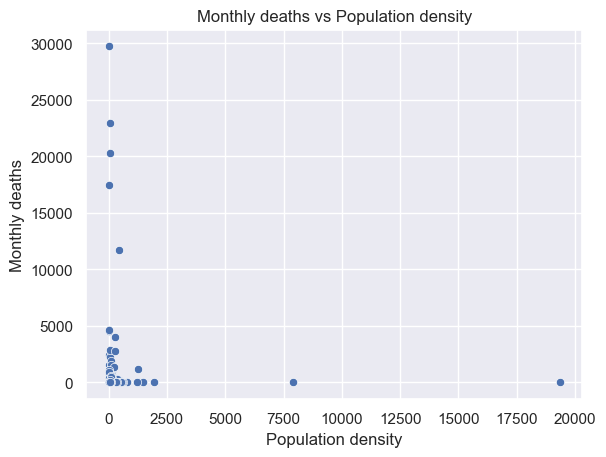

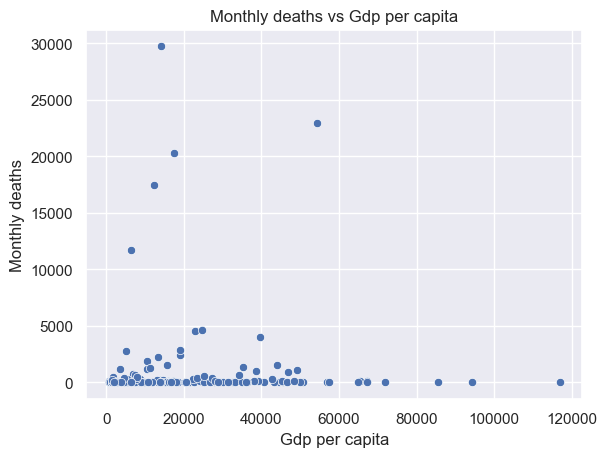

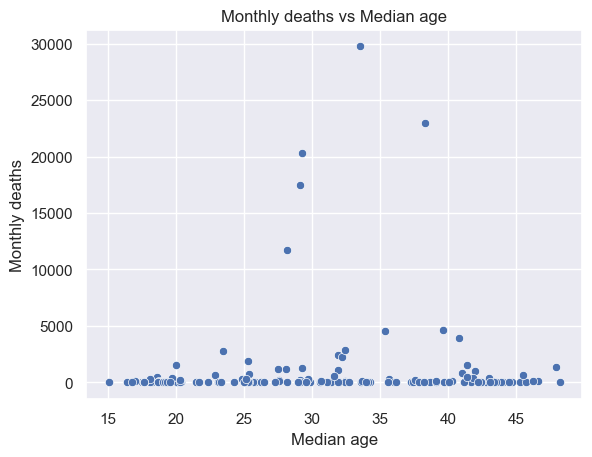

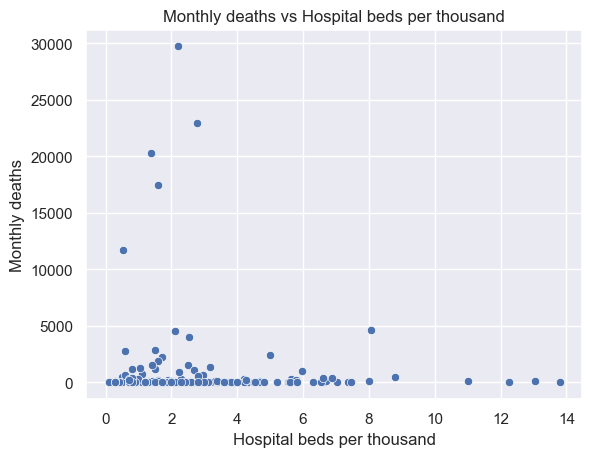

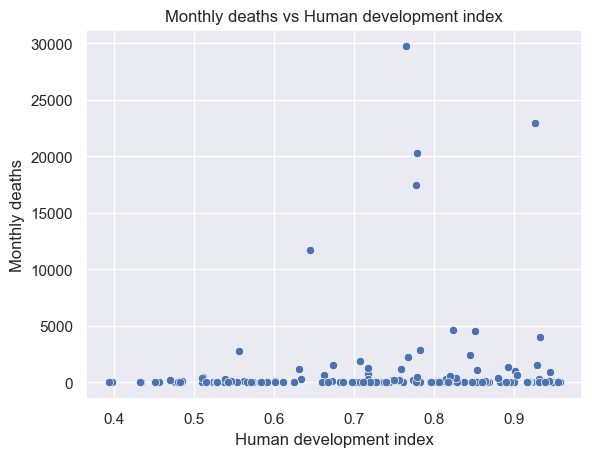

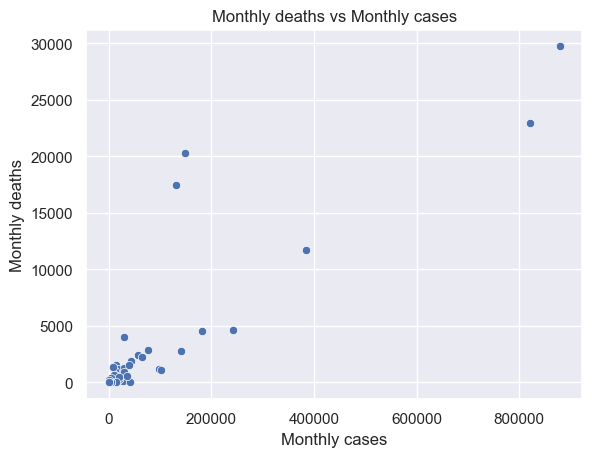

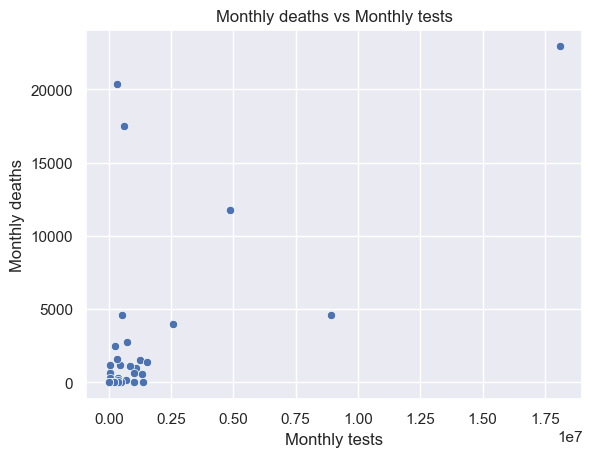

In [6]:
june_20_filter = FilterData(june_20_df)
june_20_filter.visualize(ignore_cols=['continent', 'location', 'monthly_deaths'], target_col='monthly_deaths')

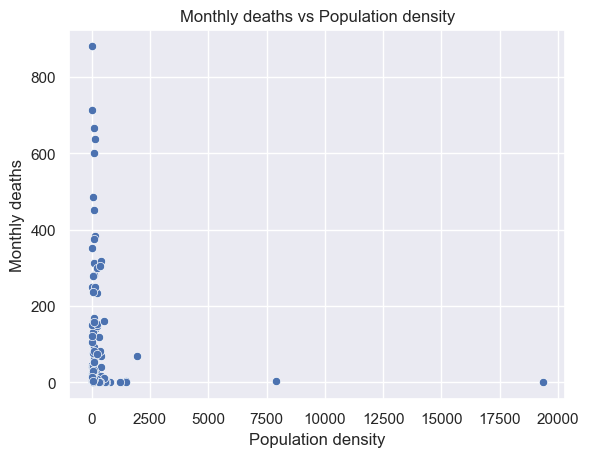

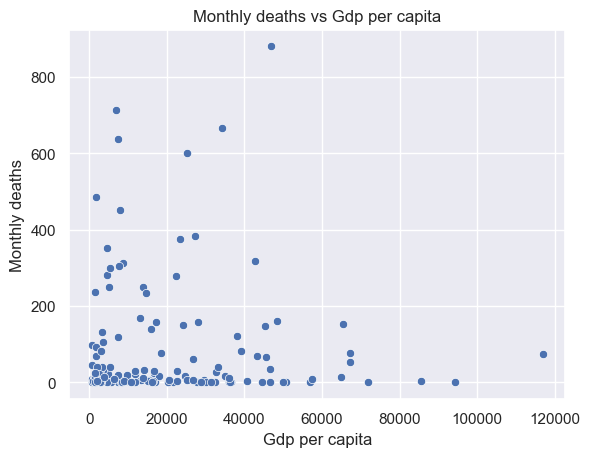

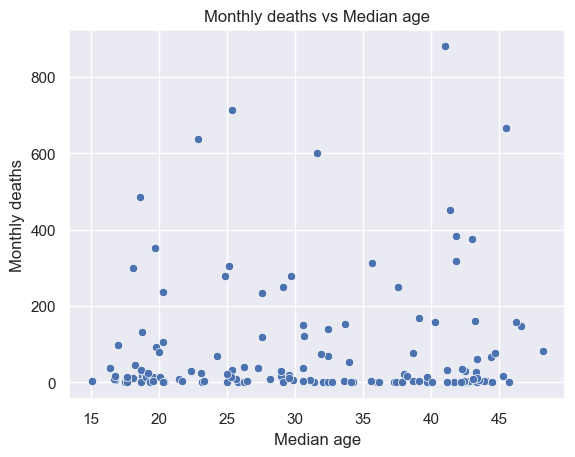

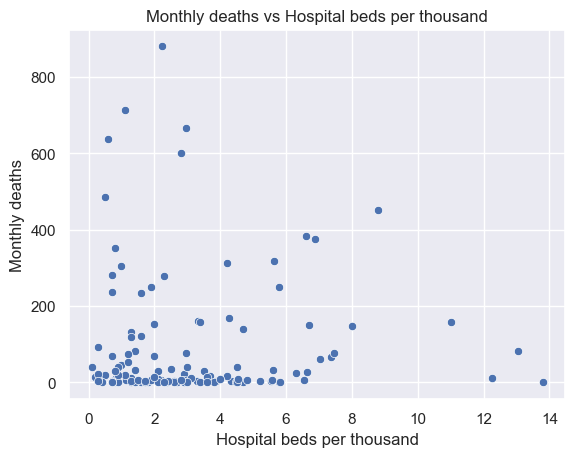

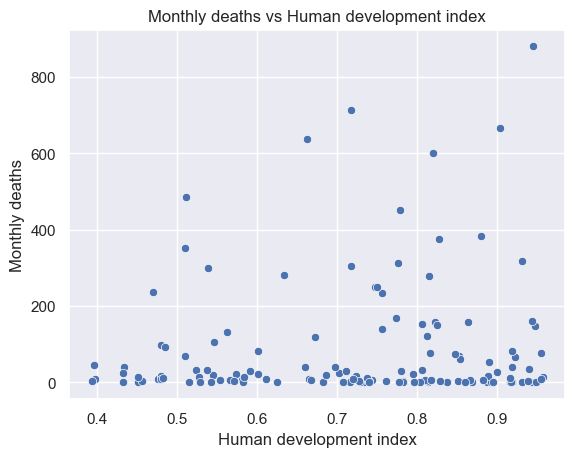

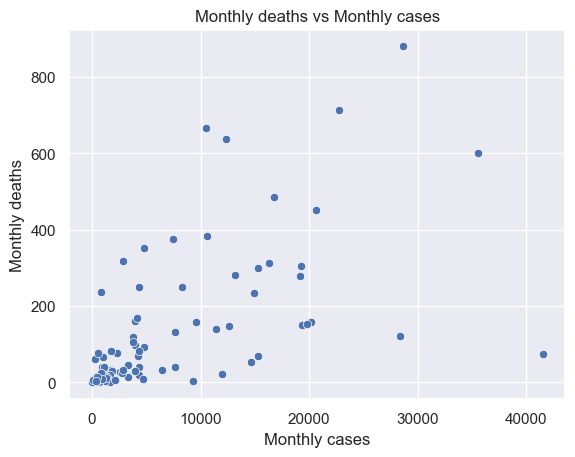

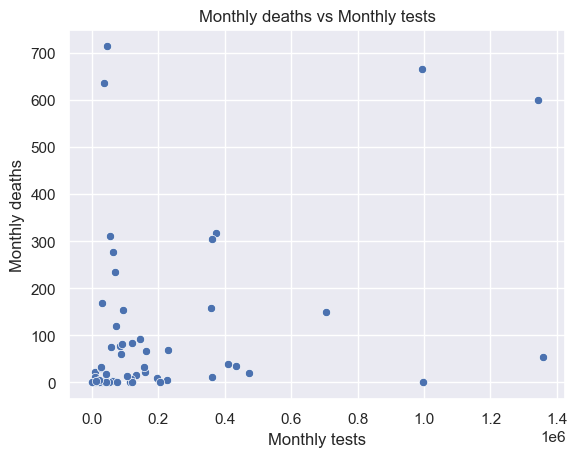

In [7]:
# Filter 
june_20_filter.filter_val(col_name='monthly_deaths', lower_bound=0, upper_bound=1000)
# Replot
june_20_filter.visualize(ignore_cols=['continent', 'location', 'monthly_deaths'], target_col='monthly_deaths')

Let's see how many data points are plotted


In [8]:
june_20_filter.get_countries_stats()

Total data points:  161

Continent stats:
 Africa           46
Europe           44
Asia             32
North America    28
South America    7 
Oceania          4 
Name: continent, dtype: int64


Total data points:  44

Continent stats:
 Europe    44
Name: continent, dtype: int64


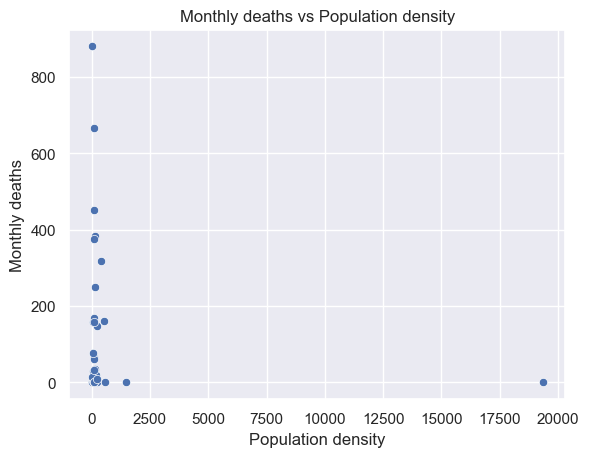

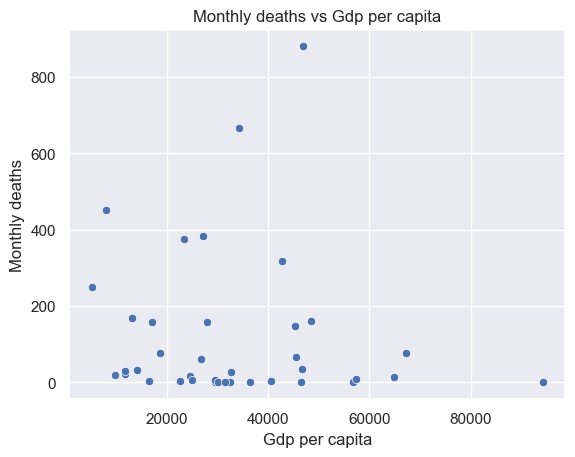

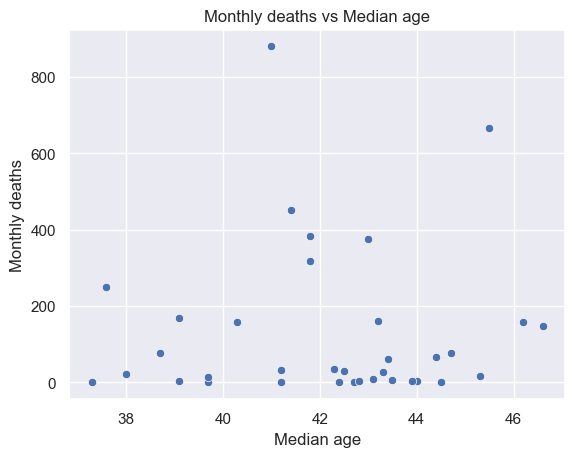

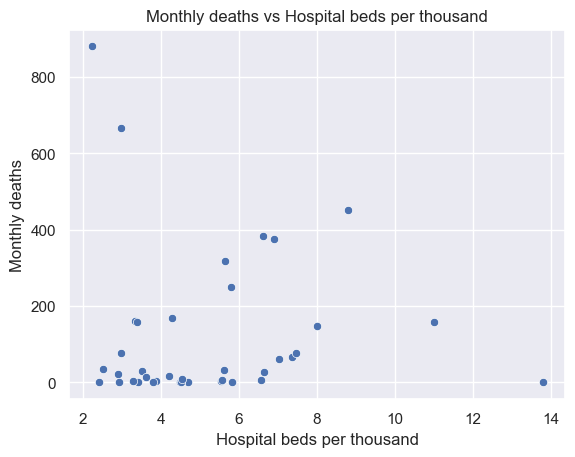

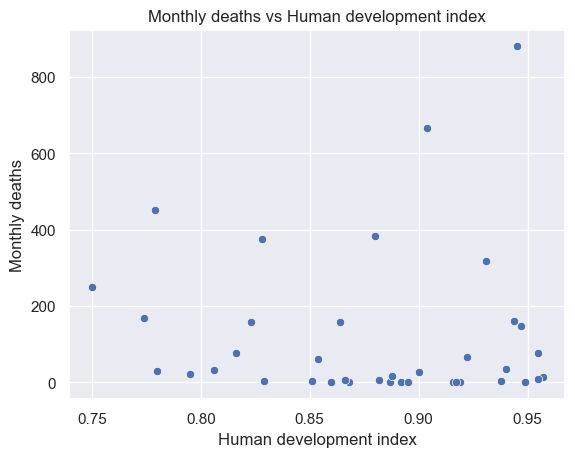

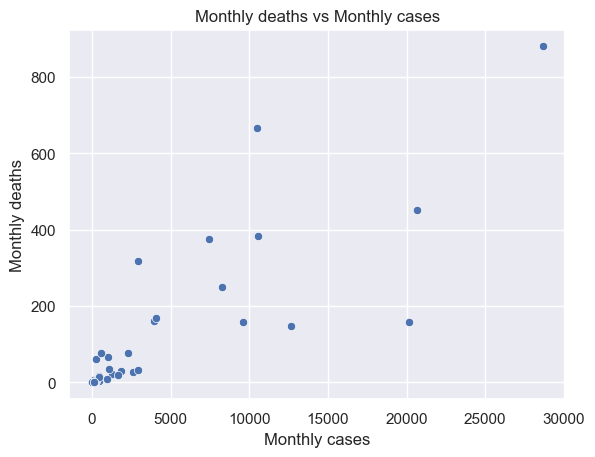

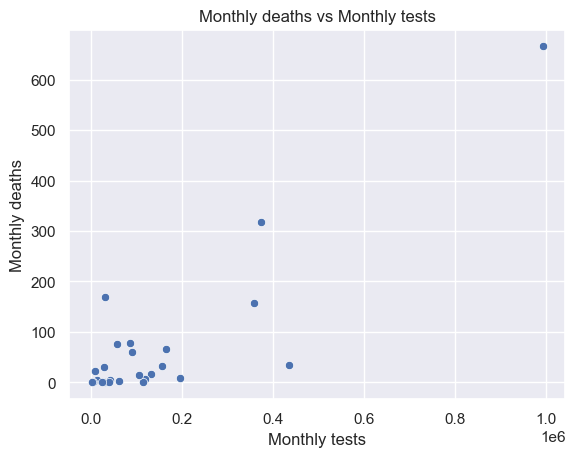

In [9]:
june_20_filter.pick_column_val(col_name='continent', val_lst=['Europe'])
june_20_filter.get_countries_stats()
# Re-Plot
june_20_filter.visualize(ignore_cols=['continent', 'location', 'monthly_deaths'], target_col='monthly_deaths')

Seeing that Population Density still has outliers, we can filter out the clear outliers from the 1st plot: monthly deaths vs population density


Total data points:  40

Continent stats:
 Europe    40
Name: continent, dtype: int64


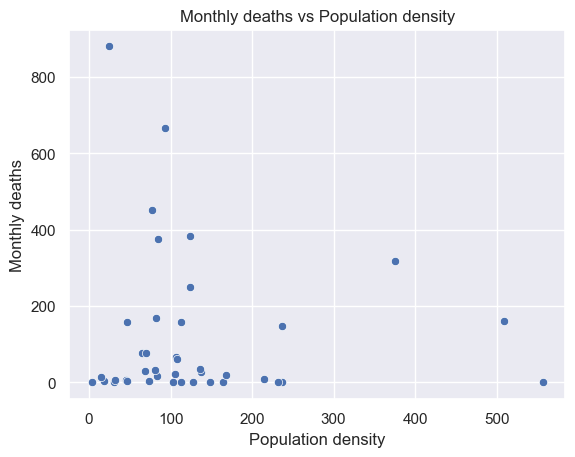

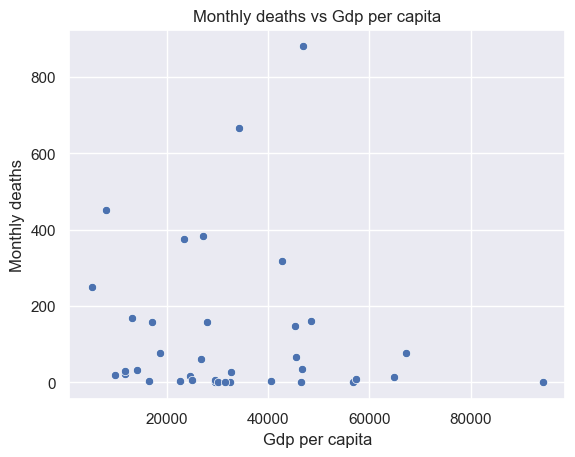

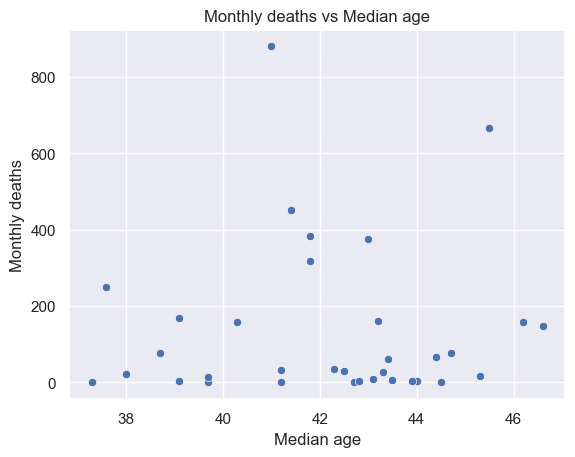

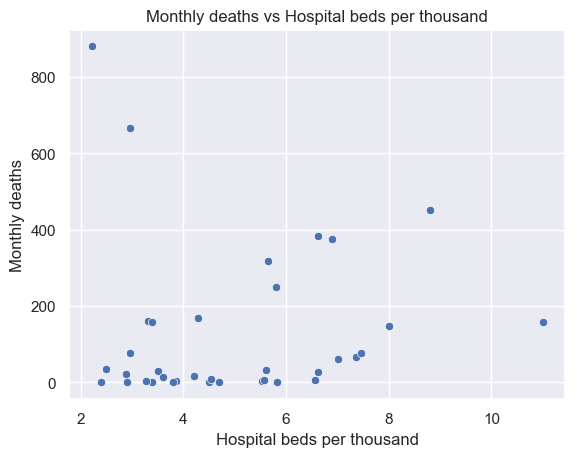

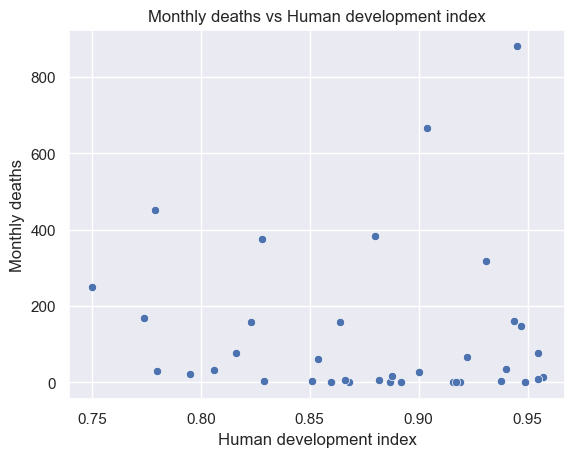

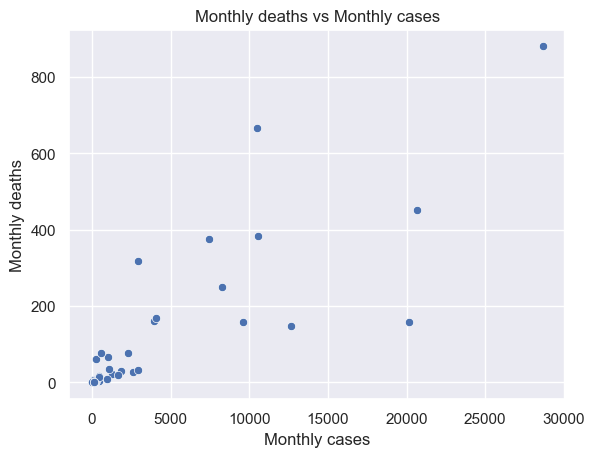

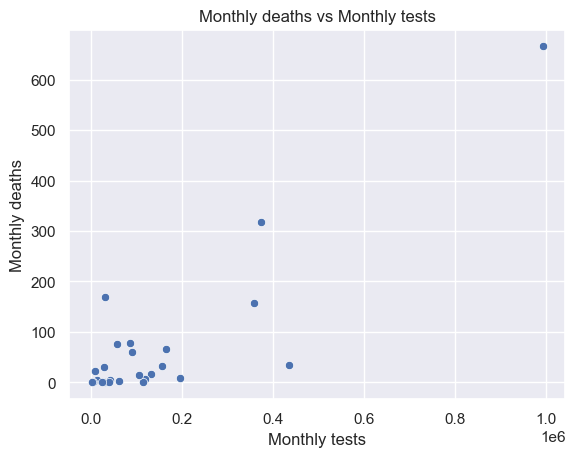

In [10]:
june_20_filter.filter_val(col_name='population_density', lower_bound=0, upper_bound=1000)
june_20_filter.get_countries_stats()
june_20_filter.visualize(ignore_cols=['continent', 'location', 'monthly_deaths'], target_col='monthly_deaths')

From here we can observe the variables and pick the Top 5 that seem to have some correlation to the sum of deaths. The variables selected are:
* population density
* GDP per capita
* Median age
* Hospital beds per thousand
* Monthly cases

In [11]:
main_cols = ['population_density', 'gdp_per_capita', 'median_age', 'human_development_index', 'monthly_cases']
june_20_filter.remove_nan(cols=main_cols)
june_20_filter.get_countries_stats(print_country=True)

Total data points:  35

Continent stats:
 Europe    35
Name: continent, dtype: int64

List of countries involved:
 ['Albania' 'Austria' 'Belarus' 'Belgium' 'Bosnia and Herzegovina'
 'Bulgaria' 'Croatia' 'Cyprus' 'Czechia' 'Denmark' 'Estonia' 'Finland'
 'Germany' 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Latvia' 'Lithuania'
 'Luxembourg' 'Moldova' 'Montenegro' 'Netherlands' 'North Macedonia'
 'Norway' 'Poland' 'Portugal' 'Romania' 'Serbia' 'Slovakia' 'Slovenia'
 'Spain' 'Sweden' 'Switzerland' 'Ukraine']


### Step 2: Perform Multiple Linear Regression

In [12]:
class MLR:
    '''
    Class to perform multiple linear regression (MLR) on a dataset
    '''
    is_zero_constant = False
    df_feature_train = None
    df_feature_test = None
    df_target_train = None
    df_target_test = None
    beta = None
    J_storage = list()
    
    
    def __init__(self, df: pd.DataFrame, feature_names: List[str], target_names: List[str], is_zero_constant: bool=False):
        '''
        Initialize separate df for features and targets and convert them to numpy array to prepare for MLR
        '''
        self._get_features_targets(df, feature_names, target_names)
        self.is_zero_constant = is_zero_constant
            
            
    def visualize_features_train(self, pred_array: Optional[np.ndarray] = None):
        '''
        Create plot to visualize individual features
        '''
        y_name = self.df_target_test.columns[0]
        y_label = y_name.replace('_', ' ')
        y_label = y_label.capitalize()
            
        if pred_array is None:
            # Plotting without prediction
            for i, x_name in enumerate(self.df_features.columns):
                myplot = plt.figure(i)
                myplot = sns.scatterplot(x=x_name, y=y_name, data=june_20_df)
                x_label = x_name.replace('_', ' ')
                x_label = x_label.capitalize()
                myplot.set_xlabel(x_label)
                myplot.set_ylabel(y_label)
                myplot.set_title(f'{y_label} vs {x_label}')
        else:
            # Plot with prediction
            for i, x_name in enumerate(self.df_features.columns):
                myplot = plt.figure(i)
                myplot = plt.scatter(self.df_feature_test[x_name], self.df_target_test, color='blue')
                myplot = plt.scatter(self.df_feature_test[x_name], pred_array, color="orange")
                x_label = x_name.replace('_', ' ')
                x_label = x_label.capitalize()
                plt.xlabel(x_label)
                plt.ylabel(y_label)
                plt.title(f'{y_label} vs {x_label}')
        
    
    def _get_features_targets(self, df: pd.DataFrame, feature_names: List[str], target_names: List[str]):
        '''
        Get feature and target cols from df
        '''
        self.df_features = df[feature_names]
        self.df_target = df[target_names]
        
        
    def split_data(self, test_size: int = 0.5, random_state: Optional[int] = None):
        '''
        Split the data into train and test set
        '''
        if test_size != 0:
            # If we are splitting
            
            # Obtain indexes randomly for splitting r
            indexes = self.df_features.index
            if random_state != None:
                np.random.seed(random_state)
            k = int(test_size * len(indexes)) 
            test_index = np.random.choice(indexes, k, replace=False)
            indexes = set(indexes)
            test_index = set(test_index)
            train_index = indexes - test_index # set subtraction
            
            # Split
            self.df_feature_train = self.df_features.loc[train_index, :] 
            self.df_feature_test = self.df_features.loc[test_index, :]
            self.df_target_train = self.df_target.loc[train_index, :]
            self.df_target_test = self.df_target.loc[test_index, :]
            
        elif test_size == 0:
            # Else no split, train and test are same set
            self.df_feature_train = self.df_features
            self.df_feature_test = self.df_features
            self.df_target_train = self.df_target
            self.df_target_test = self.df_target
            
            
    def prepare_data(self):
        '''
        Normalize features and convert feature and target to numpy array
        '''
        # normalize the feature using z normalization
        self.df_feature_train_z = self._normalize_z(self.df_feature_train)
        # convert from pd.df to np.array
        self.df_feature_train_z = self._prepare_feature(self.df_feature_train_z)
        self.df_target_train = self._prepare_target(self.df_target_train)
        
        
    def _normalize_z(self, dfin: pd.DataFrame):
        '''
        Normalize features. 
        '''
        dfout = dfin.copy()
        dfout = (dfout - dfout.mean(axis=0)) / dfout.std(axis=0)
        return dfout
    
        
    def _prepare_feature(self, dfin: pd.DataFrame):
        '''
        Convert training features df to numpy array
        '''
        if not self.is_zero_constant:
            feature_value = dfin.to_numpy()
            # make the column of ones
            ones = np.ones((dfin.shape[0], 1))
            return np.concatenate((ones, feature_value), axis=1)
        else:
            return dfin.to_numpy()


    def _prepare_target(self, dfin: pd.DataFrame):
        '''
        Convert training target df to numpy array
        '''
        return dfin.to_numpy()
        
        
    def gradient_descent(self, alpha: int, num_iters: int):
        '''
        Perform Gradient Descent
        '''
        self._beta_init()
        X, y = self.df_feature_train_z, self.df_target_train
        
        for i in range(0, num_iters):
            derivative_error = (1/(X.shape[0])) * np.matmul(X.T, np.subtract(np.matmul(X, self.beta), y))
            # update params
            self.beta = self.beta - alpha * derivative_error
            # store the error with the current parameter predictionyyyvv
            self.J_storage.append(self.compute_cost())
    
    
    def _beta_init(self):
        '''
        Initialize beta according to number of X features + 1
        '''
        if not self.is_zero_constant:
            self.beta = np.zeros((self.df_features.shape[1] + 1, 1))
        else:
            self.beta = np.zeros((self.df_features.shape[1], 1))
        

    def compute_cost(self):
        '''
        Compute cost for new parameters `beta`
        '''
        X, actual_y = self.df_feature_train_z, self.df_target_train
        J = 0
        error = np.matmul(X, self.beta) - actual_y  
        error_sq = np.matmul(error.T, error) 
        J = (1/(2*X.shape[0])) * error_sq 
        return J[0][0]

    
    def predict(self):
        '''
        Calculate predicted y_value after normalize and prepare feature test.
        '''
        X = self._prepare_feature(self._normalize_z(self.df_feature_test))
        return self._predict_norm(X, self.beta)
    
    
    def _predict_norm(self, X: np.ndarray, beta: np.ndarray):
        return np.matmul(X, beta)
    
    
    def get_r_squared(self, actual_arr: np.ndarray, pred_arr: np.ndarray) -> int:
        '''
        Find R squared according to formula: R2 = Sum of squared regressions / Total sum of squared errors
        '''
        if not self.is_zero_constant:
            mean_y = np.mean(actual_arr)
        else:
            mean_y = 0
        SSR = np.sum(np.square(np.subtract(actual_arr, pred_arr)))
        SST = np.sum(np.square(np.subtract(actual_arr, mean_y)))
        return 1 - SSR/SST
        
        
    def get_adjusted_r_squared(self, actual_arr: np.ndarray, pred_arr: np.ndarray) -> Tuple[int, int]:
        '''
        Find adjusted R squared according to formula: 1 – [((1 – R2) * (n – 1)) / (n – k – 1)]
        '''
        R2 = self.get_r_squared(actual_arr, pred_arr)
        n = len(self.df_features)
        k = len(self.beta) - 1
        return R2, 1 - ((1-R2)*(n-1)) / (n-k-1)
    
    
    def evaluate(self, actual_arr: np.ndarray, pred_arr: np.ndarray, show_params: bool=False):
        '''
        Pretty print model performance
        '''
        feature_lst = list(self.df_features.columns)
        num_features = len(feature_lst)
        R2, aR2 = self.get_adjusted_r_squared(actual_arr, pred_arr)
        print(f'Model performance for {num_features} features\n{tuple(feature_lst)}')
        print(f'- R2 = {R2}\n- adjusted R2 = {aR2}')
        
        if show_params:
            print('\nParameters obtained:\n', self.beta)
            
    
    def _get_features_combi(self, features_lst: List[str], min_num_features: int) -> List[Tuple[str]]:
        '''
        Get all combinations of features with minimum feature number equal to `min_num_feature`
        '''
        all_features_combi = list()
        for i in range(len(features_lst), min_num_features-1, -1):
            all_features_combi += list(combinations(features_lst, i))
            
        return all_features_combi
    
    
    def get_top_3_aR2(self, df: pd.DataFrame, all_features: List[str], 
                      target_names: str, test_size: int, 
                      alpha: int, num_iters: int, 
                      min_num_features: int,
                      is_zero_constant: bool = False) -> Tuple[Tuple, int, int]:
        '''
        Try all model combinations and get top three models with highest adjusted R2
        '''
        all_features_combi = self._get_features_combi(features_lst=all_features, min_num_features=min_num_features)
        all_model_performance_lst = list()
        
        # Run all the models to obtain the metrics
        for features_tup in all_features_combi:
            this_MLR = MLR(df, feature_names=list(features_tup), 
                      target_names=target_names, is_zero_constant=is_zero_constant)
            this_MLR.split_data(test_size=test_size)
            this_MLR.prepare_data()
            this_MLR.gradient_descent(alpha=alpha, num_iters=num_iters)  
            pred = this_MLR.predict()
            R2, aR2 = this_MLR.get_adjusted_r_squared(actual_arr=this_MLR.df_target_train, pred_arr=pred)
            
            all_model_performance_lst.append(tuple([features_tup, R2, aR2]))
            
        # Sort by aR2
        all_model_performance_lst.sort(key=lambda x:x[2], reverse=True)
        first, second, third = all_model_performance_lst[0], all_model_performance_lst[1], all_model_performance_lst[2]
        return first, second, third

With all 5 features, we can perform a Multi Linear Regression


In [13]:
main_df = june_20_filter.df

# Prepare features and target
june_20_MLR = MLR(main_df, feature_names=main_cols, target_names=['monthly_deaths'], is_zero_constant=False)

# Using all data for the models
june_20_MLR.split_data(test_size=0)
june_20_MLR.prepare_data()

# Gradient Descent
june_20_MLR.gradient_descent(alpha=0.01, num_iters=1500)

# Obtain prediction
pred = june_20_MLR.predict()

# Obtain metrics
june_20_MLR.evaluate(actual_arr=june_20_MLR.df_target_train, pred_arr=pred, show_params=True)

Model performance for 5 features
('population_density', 'gdp_per_capita', 'median_age', 'human_development_index', 'monthly_cases')
- R2 = 0.683393805028113
- adjusted R2 = 0.62880653003296

Parameters obtained:
 [[131.59996267]
 [ 14.30958628]
 [ -7.15382946]
 [  0.33988469]
 [ 20.66940393]
 [169.31011464]]


An adjusted R2 value of 0.774 is relatively high. But we can definitely obtain a higher adjusted R2 value by trying other combination of the features.
Let's get the top 3 models

In [14]:
first, second, third = june_20_MLR.get_top_3_aR2(df=main_df, all_features=main_cols, target_names=['monthly_deaths'], 
                          test_size=0, alpha=0.01, num_iters=1500, min_num_features=1, is_zero_constant=False)
for model in (first, second, third):
    features = model[0]
    R2, aR2 = model[1], model[2]
    print(f'Model performance for {len(features)} features\n{tuple(features)}')
    print(f'- R2 = {R2}\n- adjusted R2 = {aR2}')
    print()

Model performance for 1 features
('monthly_cases',)
- R2 = 0.6702511814947754
- adjusted R2 = 0.6602587930552231

Model performance for 2 features
('human_development_index', 'monthly_cases')
- R2 = 0.6787021099590838
- adjusted R2 = 0.6586209918315264

Model performance for 2 features
('population_density', 'monthly_cases')
- R2 = 0.6777051238822023
- adjusted R2 = 0.6575616941248399



* Trying different combinations of the 5, we finally decided on using ‘Population Density’, ‘Monthly Cases’ and ‘Human Development Index’ as they gave us the best value of adjusted R2.
* Using these metrics to test accuracy, we can see that the model is moderately accurate, with 0.788 of the actual readings fitting the model that we have, giving us the ability to predict the number of deaths fairly accurately.

### Step 3: Visualize prediction
* For our highest score model with 3 features, we get: ('population_density', 'human_development_index', 'monthly_cases')
* We can then rerun it and plot our prediction

In [15]:
# Prepare features and target
main_MLR = MLR(main_df, feature_names=list(first[0]), target_names=['monthly_deaths'], is_zero_constant=False)

# Using all data for the models
main_MLR.split_data(test_size=0)
main_MLR.prepare_data()

# Gradient Descent
main_MLR.gradient_descent(alpha=0.01, num_iters=1500)

# Obtain prediction
pred = main_MLR.predict()

# Obtain metrics
main_MLR.evaluate(actual_arr=main_MLR.df_target_train, pred_arr=pred, show_params=True)

Model performance for 1 features
('monthly_cases',)
- R2 = 0.6702511814947754
- adjusted R2 = 0.6602587930552231

Parameters obtained:
 [[131.59996267]
 [167.12123712]]


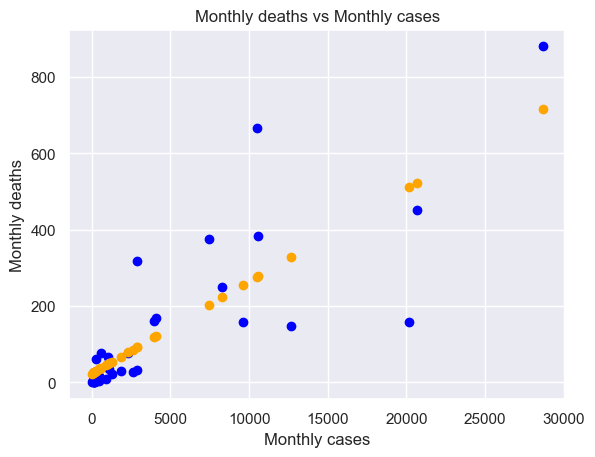

In [16]:
main_MLR.visualize_features_train(pred_array=pred)

### Step 4: Analysis
* We only pick 3 features since we have quite a limited number of data points (34 countries).
* However, we are still only able to obtain a relatively high adjusted R2 value of about 80%. This means that 80% of the COVID death counts in June 2020 could be predicted by our model.
* Our adjusted R2 value is also quite close to the model obtained from Excel.
* Due to how we filtered the data, the model is most accurate within the range of population density 3-510 as the data we used exists only within that range, after having eliminated outliers.